# Running the trained model

[TODO] Add a lot of surrounding description and infom

# train-and-predict.py

- Originally based on: https://github.com/jocicmarko/ultrasound-nerve-segmentation
- Heavily modified for retina segmentation

# Importing the libraries

In [1]:
%matplotlib inline

import os
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 512
img_rows = 512

smooth = 1.

model_dir = 'models/'

# Optimisation function

In [ ]:
Dice equation

In [9]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Deep network

Model

In [12]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2),)(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # TODO: temporary switch from 5e-5 to 1e-5
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    print('model created')

    return model


# Training

In [5]:

options = {}
options['augmentation'] = True

epochs = 2001
batch_size = 5

print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

train_data = np.load('data/DRIVE/imgs_train.npz')
imgs_train, imgs_mask_train = train_data['imgs'], train_data['imgs_mask']

img_test = imgs_train[-1]
img_mask_test = imgs_mask_train[-1]
img_test = np.expand_dims(img_test, axis=0)
img_mask_test = np.expand_dims(img_mask_test, axis=0)
imgs_train = np.delete(imgs_train, -1, 0)
imgs_mask_train = np.delete(imgs_mask_train, -1, 0)

imgs_train = imgs_train.astype('float32')
imgs_train = imgs_train / imgs_train.max()

# mean = np.mean(imgs_train)  # mean for data centering
# std = np.std(imgs_train)  # std for data normalization
#
# imgs_train -= mean
# imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train = imgs_mask_train > 0.5

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()

print('-'*30)
print('Fitting model...')
print('-'*30)


------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
model created
------------------------------
Fitting model...
------------------------------


# Data augmentation

- Excerpts from the training function above

In [6]:


# Data augmentation
# Image generation from:
# https://keras.io/preprocessing/image/

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=10.,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     zoom_range=0.1,
                     fill_mode='constant',
                     cval=0)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(imgs_train, augment=True, seed=seed)
mask_datagen.fit(imgs_mask_train, augment=True, seed=seed)

image_generator = image_datagen.flow(imgs_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(imgs_mask_train, batch_size=batch_size, seed=seed)

gen1 = zip(image_generator, mask_generator)


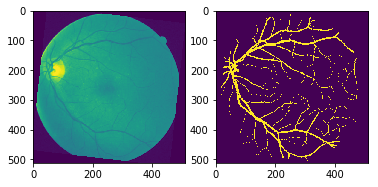

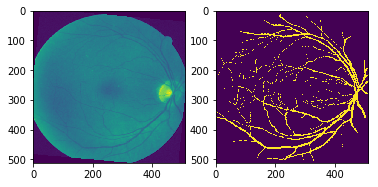

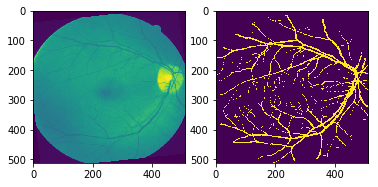

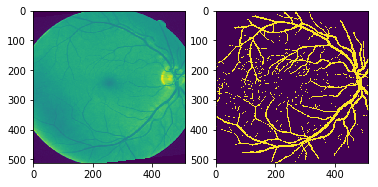

In [9]:
batches = 0
for x_batch, y_batch in gen1:
    y_batch = y_batch > 0.5
    model.fit(x_batch, y_batch, verbose=0, epochs=1)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(x_batch[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(y_batch[0]))
    
    batches += 1
    if batches >= len(imgs_train) / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
        
plt.show()


# Why? 

In [ ]:

# here's a more "manual" example
for e in range(epochs):

    batches = 0
    for x_batch, y_batch in gen1:
        y_batch = y_batch > 0.5
        model.fit(x_batch, y_batch, verbose=0, epochs=1)

        # plt.figure()
        # plt.imshow(np.squeeze(x_batch[0]))
        # plt.figure()
        # plt.imshow(np.squeeze(y_batch[0]))
        # plt.show()

        batches += 1
        if batches >= len(imgs_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    if e % 500 == 0:

        print('Epoch', e)

        # Show a single case

        print('Epoch {}'.format(e))

        pred1 = model.predict(img_test)

        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title('Example')
        plt.imshow(np.squeeze(img_test))
        plt.subplot(1, 3, 2)
        plt.title('Model Epoch {}'.format(e))
        plt.imshow(np.squeeze(pred1))
        plt.subplot(1, 3, 3)
        plt.title('Ground truth')
        plt.imshow(np.squeeze(img_mask_test))
        plt.show()

        model.save_weights(model_dir + "modelaug{}.h5".format(e))


# Images

![img/training0.png](img/training0.png)
![img/training400.png](img/training400.png)
![img/training800.png](img/training800.png)
![img/training1200.png](img/training1200.png)

In [13]:
def dice_coeff_standard(yt, yp):

    yt = yt > 0.5
    yp = yp > 0.5

    return 2*np.sum(np.logical_and(yt, yp)) / (np.sum(yt) + np.sum(yp))


def predict():

    model = get_unet()

    print('- ' * 30)
    print('Loading and preprocessing test data...')
    print('- ' * 30)

    test_data = np.load('data/DRIVE/imgs_test.npz')
    imgs_test, imgs_mask_test = test_data['imgs'], test_data['imgs_mask']

    imgs_test = imgs_test.astype('float32')
    imgs_test = imgs_test / imgs_test.max()
    # imgs_test -= mean
    # imgs_test /= std

    print('- ' * 30)
    print('Loading saved weights...')
    print('- ' * 30)
    model.load_weights('models/modelaug3900.h5')

    print('- ' * 30)
    print('Predicting masks on test data...')
    print('- ' * 30)

    imgs_mask_pred = model.predict(imgs_test[:5], verbose=1)

#     np.save('imgs_mask_test.npy', imgs_mask_test)

    dice_all = []

    for impred, im, imtest in zip(imgs_mask_pred[:5], imgs_test[:5], imgs_mask_test[:5]):

        dice_all.append(dice_coeff_standard(imtest, impred))

        plt.figure()
        plt.title("Ground truth and prediction for test set. Dice {}".format(dice_all[-1]))

        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(im))
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(imtest))
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(impred))

    plt.show()

    print("Mean dice: ", np.mean(dice_all))


model created
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading and preprocessing test data...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading saved weights...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Predicting masks on test data...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
5/5 [==============================] - 0s 51ms/step


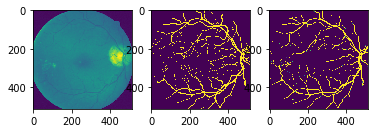

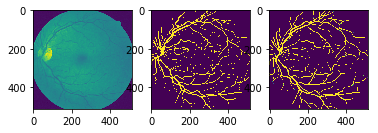

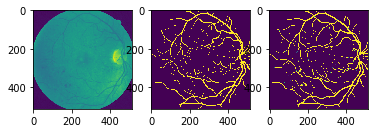

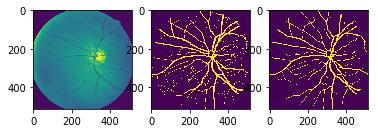

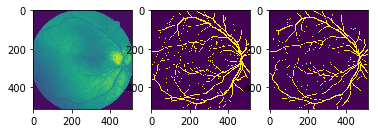

Mean dice:  0.7858877641007169


In [14]:
predict()

model created
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading saved weights...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Layer shape:  (1, 512, 512, 32)
Layer shape (montage):  (32, 512, 512)
Layer shape:  (1, 128, 128, 128)
Layer shape (montage):  (128, 128, 128)
Layer shape:  (1, 32, 32, 512)
Layer shape (montage):  (512, 32, 32)
Layer shape:  (1, 128, 128, 128)
Layer shape (montage):  (128, 128, 128)
Layer shape:  (1, 512, 512, 32)
Layer shape (montage):  (32, 512, 512)


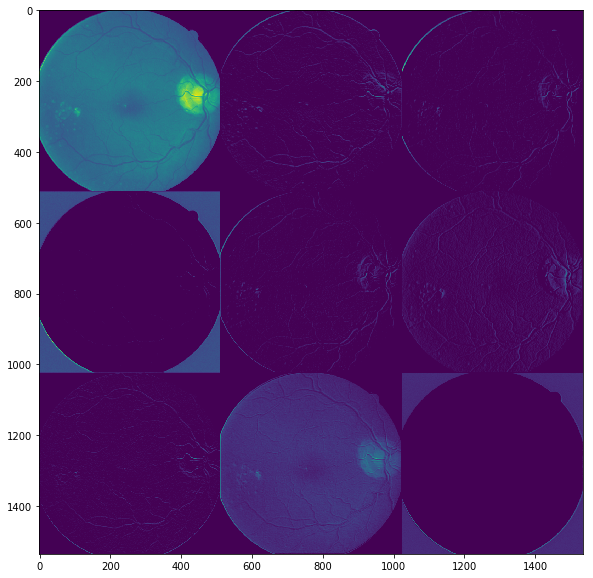

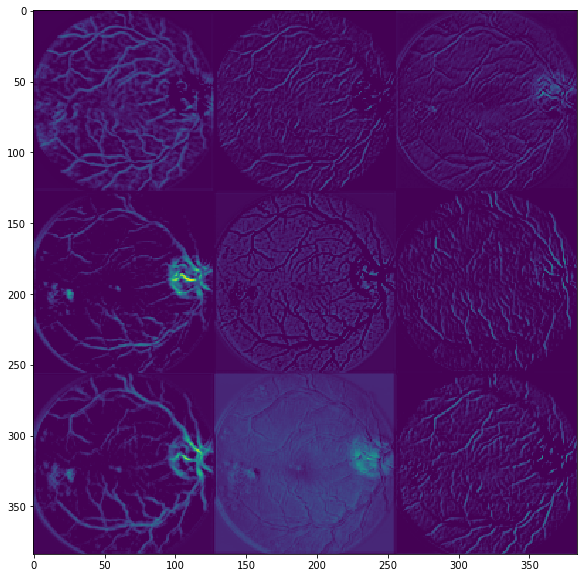

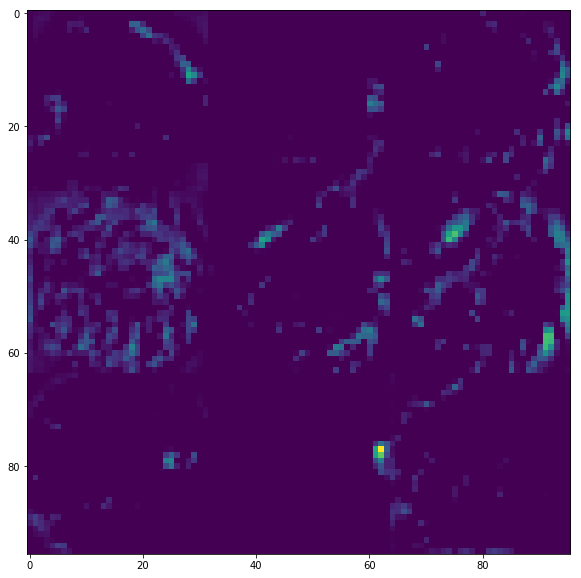

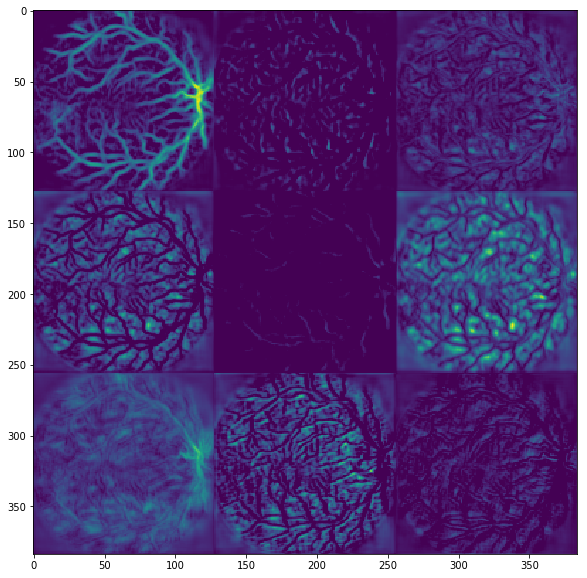

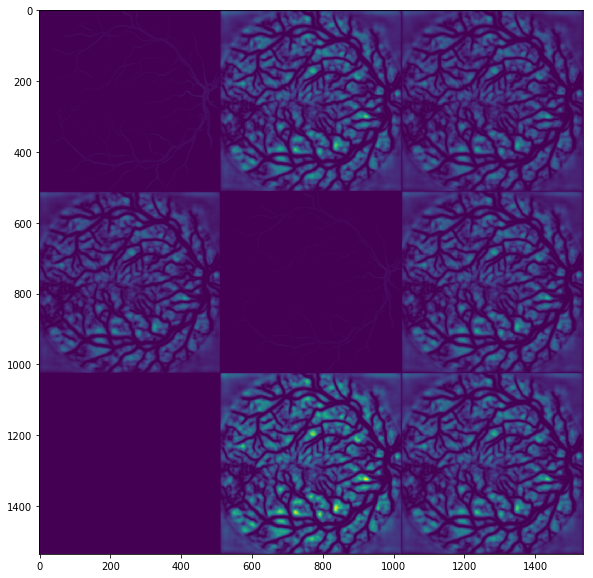

In [37]:
# Importing montage function
from skimage.util import montage
pd.options.display.max_rows = 4000

# Reloading the test data
test_data = np.load('data/DRIVE/imgs_test.npz')
imgs_test, imgs_mask_test = test_data['imgs'], test_data['imgs_mask']
imgs_test = imgs_test.astype('float32')
imgs_test = imgs_test / imgs_test.max()

# Extracting 1 example
example_image = imgs_test[0]
example_image = np.expand_dims(example_image, axis=0)

layer_vis = ['conv1', 'conv3', 'conv5', 'conv7', 'conv9']

model = get_unet()
print('- ' * 30)
print('Loading saved weights...')
print('- ' * 30)
model.load_weights('models/modelaug3900.h5')

for l1name in layer_vis:
    
    l1_model = model.get_layer(l1name)
    l1_function = K.function([model.layers[0].input, K.learning_phase()], [l1_model.output])
    l1_output = l1_function([example_image, 0])[0]
    
    print("Layer shape: ", l1_output.shape)
    
    l1_output = np.squeeze(l1_output)
    l1_output = np.rollaxis(l1_output, 2, 0)
    
    print("Layer shape (montage): ", l1_output.shape)
    
    plt.figure(figsize=(10,10))
    m1 = montage(l1_output[:9])
    plt.imshow(m1)

#     img_width = layer_output.shape[1]
#     img_height = layer_output.shape[2]
#     n = int(np.floor(np.sqrt(l1_output.shape[-1])))
    
    
    
    